# Dataset: Titanic - Machine Learning from Disaster

## 1 Descripción

El conjunto de datos objeto de análisis se ha obtenido a partir del siguiente enlace de Kaggle: https://www.kaggle.com/c/titanic/data. Dicho conjunto de datos contiene 891 muestras en el conjunto de entrenamiento y 418 en el conjunto de test, todas ellas constituidas por 12 características (columnas). Dichas características son las siguientes:

-	**PassengerId:** El identificador único del pasajero.
-	**Pclass:** La clase en la que viajaba el pasajero. Puede tomar los siguientes valores:
  - 1 = 1º clase
  - 2 = 2ª clase
  - 3 = 3ª clase
-	**Name:** El nombre del pasajero.
-	**Sex:** El sexo del pasajero. Puede tomar los siguientes valores:
  - Male
  - Female
-	**Age:** La edad del pasajero.
-	**SibSp:** Número de hermanos/marido/mujer del pasajero a bordo.  
-	**Parch:** Número de padres/hijos del pasajero a bordo.
-	**Ticket:** Número de ticket del pasajero.
-	**Fare:** Precio del pasaje.
-	**Cabin:** Número de cabina en la que viajaba el pasajero.
-	**Embarked:** Puerto en el que embarcó el pasajero. Puede tomar los siguientes valores:
  - C = Cherbourg
  - Q = Queenstown
  - S = Southampton
-	**Survived:** Indicia si el pasajero sobrevivió o no. Puede tomar los siguientes valores:
  - 0 = No sobrevivió
  - 1 = Sobrevivió

El objetivo final del análisis será tratar de detectar patrones y determinar las características que se debían de cumplir para sobrevivir.

## 2 Integración y selección de los datos de interés a analizar

Para nuestro análisis, vamos a obviar algunas de las características puesto que, a priori, no son de utilidad para nuestro objetivo. Dichas características son:
-	**Name:** El nombre del pasajero no nos aportará nada a nuestro análisis.
-	**Ticket:** El número de ticket del pasajero, a priori, no es de utilidad. Sería interesante saber si dicho número sigue algún patrón que lo relacione con la localización dentro del barco puesto que nos ofrecería información adicional, pero parece ser que no es el caso por lo que obviaremos dicha información.
-	**Cabin:** El número de cabina en la que viajaba el pasajero. Esta columna sería muy interesante si tuviéramos un mapa que nos permitiera situar cada cabina con la localización en el barco (por ejemplo, su cercanía a los botes salvavidas). No es el caso, y además esta columna es desconocida para prácticamente todas las muestras, por lo que también la obviaremos.

Por otro lado, en el conjunto de test, la información sobre si el pasajero sobrevivió o no se encuentra en un fichero separado. Para nuestro análisis juntaremos ambos conjuntos de datos (test y train) en uno solo. Una vez hayamos juntado los datos, la columna **PassengerId** dejará de ser necesaria por lo que no la incluiremos tampoco.

Además, las columnas **SibSp** y **Parch** ofrecen información en relación a los familiares que viajaban con los pasajeros. Para simplificar nuestro análisis, juntaremos dicha información en una nueva columna **FamilySize**. Además, puede ser que el hecho de viajar solo tenga una fuerte influencia en el hecho de sobrevivir o no, por lo que también crearemos una nueva columna **IsAlone** que tomará los valores 0 si el pasajero no viaja solo o 1 si viaja solo.

En resumen, nuestro análisis se basará en las siguientes características: **Pclass, Sex, Age, FamilySize, IsAlone, Fare, Embarked, Survived**.


## 3 Limpieza de los datos

### 3.1 Carga de los datos

Lo primero que haremos será cargar los datos de los ficheros CSV y juntarlos en 1 conjunto de datos con el tipo de dato mas adecuado para cada caso.

In [1]:
# Cargamos las librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy import stats
import math

In [90]:
# Cargamos los datos
train_df = pd.read_csv("./sample_data/train.csv")
test_df = pd.read_csv("./sample_data/test.csv")
survival_df = pd.read_csv("./sample_data/gender_submission.csv")

# Juntamos los datos de test con la información sobre la supervivencia de los pasajeros
test_df = test_df.merge(survival_df, left_index=True, right_index=True, how="inner")

In [91]:
# Agrupamos los conjuntos de datos de test y train en uno solo
columns_to_drop_test = ["PassengerId_x","PassengerId_y","Name","Ticket","Cabin"]
columns_to_drop_train = ["PassengerId","Name","Ticket","Cabin"]

test_df = test_df.drop(columns_to_drop_test, axis=1)
train_df = train_df.drop(columns_to_drop_train, axis=1)

all_df = pd.concat([train_df, test_df], sort=True).reset_index()[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]]

In [92]:
# Mostramos una descripción de los datos cuantitativos
all_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,0.377387,2.294882,29.881138,0.498854,0.385027,33.295479
std,0.484918,0.837836,14.413493,1.041658,0.865560,51.758668
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


### 3.2 Ceros y elementos vacíos

El siguiente paso será realizar un análisis previo para detectar si existen valores desconocidos en nuestro conjunto de datos. Para ello listaremos los campos en los que se detectan elementos vacíos.

In [5]:
# Identificación de los valores vacíos
print(all_df.isnull().any())

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare         True
Embarked     True
dtype: bool


Se detectan valores desconocidos en los campos **Age**, **Fare** y **Embarked**.

En el caso de **Age** y **Fare**, imputaremos los valores utilizando la mediana del conjunto de datos agrupado por **Sex** y **Pclass**.

En el caso de **Embarked** simplemente utilizaremos el valor más frecuente, en este caso "S".

In [93]:
#Age y Fare: Imputación por mediana del mismo sexo y Pclass
def fill_column(df_grouped, row, column):
    return df_grouped[(df_grouped["Sex"] == row["Sex"]) & (df_grouped["Pclass"] == row["Pclass"])][column].values[0]
def process_column_by_sex_and_class(df, df_grouped, column):
    df[column] = df.apply(lambda row: fill_column(df_grouped, row, column) if np.isnan(row[column]) else row[column], axis=1)

all_df_grouped = all_df.groupby(["Sex", "Pclass"])
all_df_grouped = all_df_grouped.median()
all_df_grouped = all_df_grouped.reset_index()[["Sex", "Pclass", "Age", "Fare"]]
all_df_imputed = all_df.copy()
process_column_by_sex_and_class(all_df_imputed, all_df_grouped, "Age")
process_column_by_sex_and_class(all_df_imputed, all_df_grouped, "Fare")

In [94]:
#Embarked: Imputación al valor más frecuente
all_df_imputed.groupby("Embarked").count()
#Imputamos el valor más común para este campo
all_df_imputed["Embarked"].fillna("S", inplace=True)

In [95]:
#FamilySize: Creamos una nueva columna que agrupe Parch y SibSp en una sola columna indicando el tamaño de la familia
all_df_imputed["FamilySize"] = all_df_imputed["Parch"] + all_df_imputed["SibSp"] + 1
all_df_imputed = all_df_imputed.drop(["Parch","SibSp"], axis=1)

In [96]:
#IsAlone: Creamos una nueva columna que indique si el pasajero viajaba solo en función del tamaño de la familia
all_df_imputed["IsAlone"] =[1 if i<2 else 0 for i in all_df_imputed["FamilySize"]]

### 3.. Valores extremos

Finalmente vamos a visualizar la distribución de las variables cuantitativas para ver si existen valores extremos o outliers que puedan significar valores erróneos.

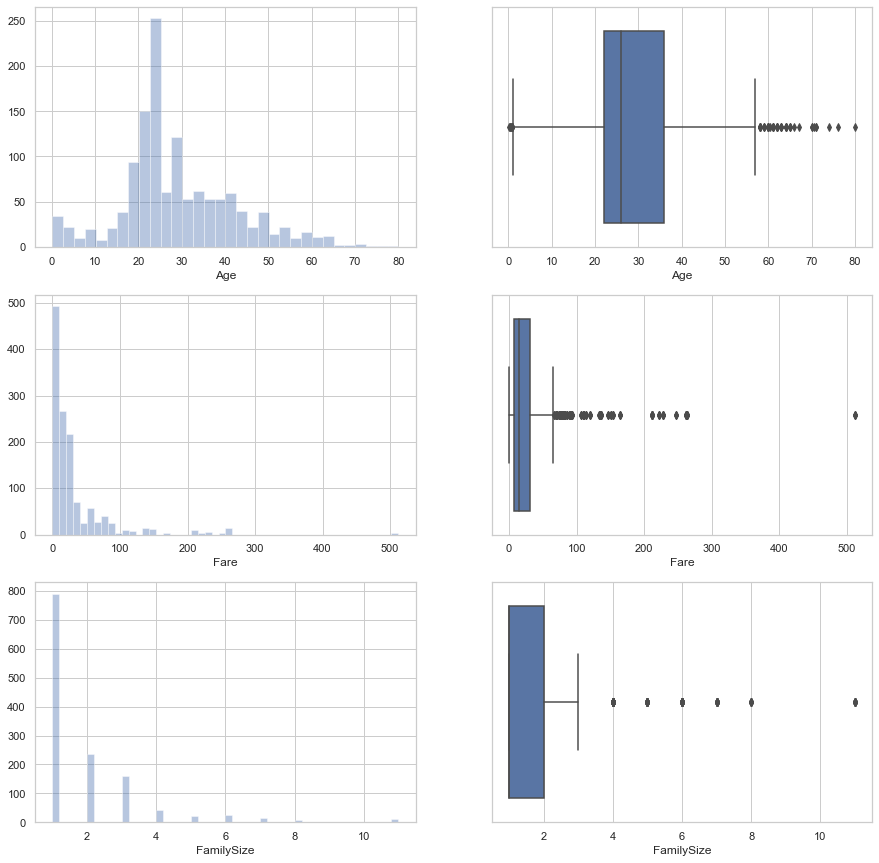

In [97]:
#Identificación de valores outliers 
numeric_variables = ["Age","Fare","FamilySize"]

f, axes = plt.subplots(len(numeric_variables), 2, figsize=(15, 15))
sns.set(style="whitegrid")

for i, variable in enumerate(numeric_variables):
    sns.distplot(all_df_imputed[variable], kde=False, ax=axes[i,0])
    sns.boxplot(x=all_df_imputed[variable], ax=axes[i,1])

En principio, los valores extremos observados entran dentro de lo posible y para evitar eliminar o modificar datos correctos, procederemos con el análisis manteniéndolos.

### 3.4 Exportación de los datos preprocesados

Una vez hemos preprocesado y limpiado los datos, procedemos a su exportación para permitir su uso futuro.

In [11]:
# Exportamos los datos preprocesados a un fichero CSV
all_df_imputed.to_csv("./sample_data/titanic_preprocessed.csv", index=False)

## 4 Análisis de los datos

### 4.1. Selección de los grupos de datos a analizar/comparar.

El primer paso que vamos a realizar va a ser comprobar la correlación entre las distintas variables del conjunto de datos, para tener una primera estimación de que características fueron más determinantes para la supervivencia de los pasajeros.

Para poder realizar el cálculo anterior, vamos a convertir todas las variables de tipo carácter a numéricas.

In [12]:
# Codificamos nuestras variables categoricas a variables numéricas
# Sex
all_df_imputed_proc = all_df_imputed.copy()
all_df_imputed_proc["Sex"] = all_df_imputed.apply(lambda row: 0 if row["Sex"]=="male" else 1, axis=1)
#Embarked
all_df_imputed_proc_dummies = pd.get_dummies(all_df_imputed_proc["Embarked"], prefix="Embarked")
all_df_imputed_proc = pd.concat([all_df_imputed_proc, all_df_imputed_proc_dummies], axis=1)
all_df_imputed_proc.drop("Embarked", axis=1, inplace=True)

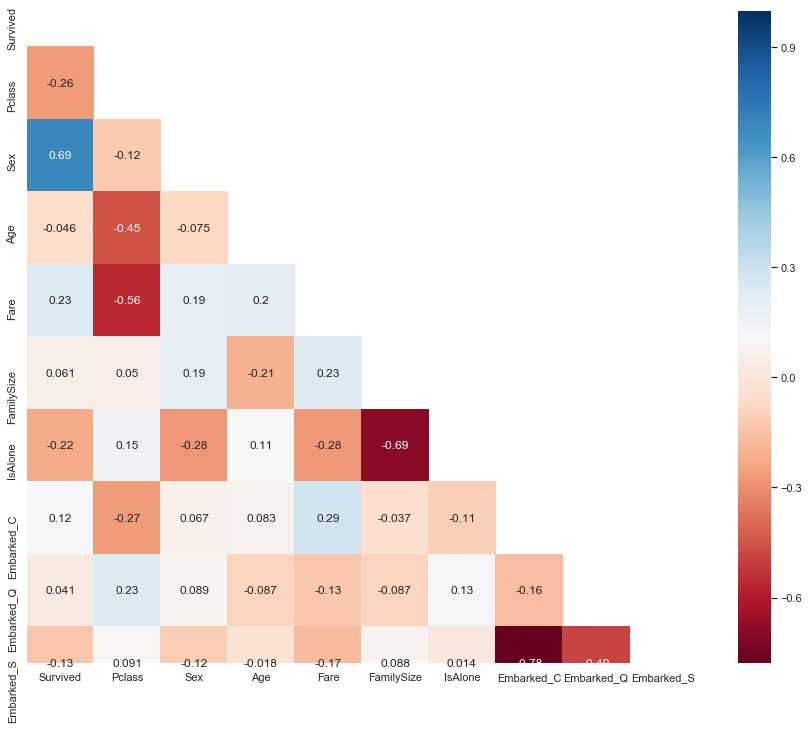

In [13]:
#Visualizamos la correlación entre las variables del conjunto
plt.subplots(figsize=(15,12))
mask = np.zeros_like(all_df_imputed_proc.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(all_df_imputed_proc.corr(), annot=True, mask=mask, cmap='RdBu');

Como vemos en la figura anterior, donde se representan las correlaciones entre las distintas variables en forma de mapa de calor, se observa una importante relación entre la tarifa que pagaron los pasajeros y el índice de supervivencia, y entre el hecho de viajar solo y el índice de supervivencia. Aún así, el mayor valor se observa entre el sexo del pasajero y la probabilidad de sobrevivir. Por este motivo, centraremos nuestro estudio en dichos campos.

También comprobaremos si entre los grupos de supervivientes, separados por sexo, hay alguna diferencia respecto la edad de los pasaejos que sobrevivieron.


### 4.2 Comprobación de la normalidad y homogeneidad de la varianza

Los elementos a analizar en el apartado anterior son, por una parte, el índice de supervivencia en función de distintas agrupaciones que vamos a realizar, y, por otra, la edad de los pasajeros que sobrevivieron.

La variable 'Survived', que nos informa si un pasajero sobrevivió o no al hundimiento, es de tipo categorica y por lo tanto no tiene una distribución normal. Para estos casos, en base al teorema del límite central, podemos afirmar que para conjuntos de más de 30 muestras se puden hacer contrastes entre la diferencia de medianas, siendo esta mediana el índice de supervivencia de cada uno de los grupos, calculado como la media de la variable 'Survived' para cada grupo.

Por otra parte, para la variable 'Age', sobre la que también realizaremos un análisis, vamos a comprobar que siga una distribución normal y que la varianza sea homogenia.

In [14]:
male_survived = all_df_imputed_proc[(all_df_imputed_proc["Sex"] == 0) & (all_df_imputed_proc["Survived"] == 1)]
female_survived = all_df_imputed_proc[(all_df_imputed_proc["Sex"] == 1) & (all_df_imputed_proc["Survived"] == 1)]

#Comprovación de la normalidad
print(stats.shapiro(male_survived.Age))
print(stats.shapiro(female_survived.Age))


(0.9624548554420471, 0.003654781961813569)
(0.963165283203125, 2.9619211971976256e-08)


Observamos que en ambos casos, el valor *p* retornado (el segundo parámetro del print) es menor a 0.05 y por lo tanto, no podemos considerar que la edad siga una distribución normal, lo podemos comprobar también de forma gráfica:

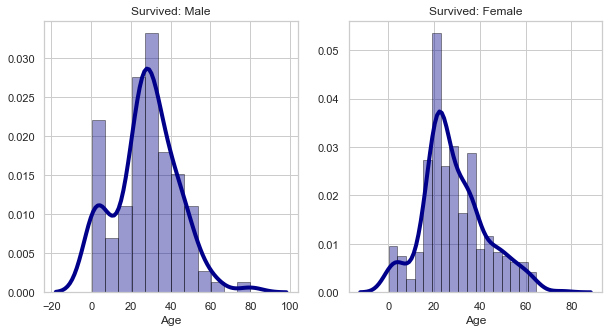

In [15]:
f, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.distplot(male_survived.Age, hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             ax=axes[0])
axes[0].set_title('Survived: Male');

sns.distplot(female_survived.Age, hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             ax=axes[1])
axes[1].set_title('Survived: Female');

Como estamos tratando con muestras con distribución no-normal, utilizaremos el test de Fligner-Killeen para comprobar si las varianzas para la edad son iguales en ambos sexos:

In [16]:
#Comprovación de la homogeneidad de la varianza
stats.fligner(male_survived.Age, female_survived.Age )

FlignerResult(statistic=0.6308856525678793, pvalue=0.42703063675190367)

El resultado nos devuelve un valor *p* de $0.427 > 0.05$, por lo tanto, podemos asegurar que ambos grupos tienen varianzas estadísticamente iguales.

### 4.3 Pruebas estadísticas

#### 4.3.1 ¿Qué variables influyen más en la superviviencia?

Como ya hemos visto en el apartado anterior, las variables que influyen más en la supervivencia del pasajero son, en orden descendente:
- Sex
- Pclass / Fare (estos dos campos tienen una fuerte correlación por lo que las estudiaremos conjuntamente)
- Is Alone

Vamos a comprobar de qué manera influye cada una de ellas.

#### 4.3.2 Sex vs Survived

Planteamos la siguientes hipotesis que validaremos a continuación:

*   Hipotesis nula $H_{0}$ - El índice de supervivencia es igual para hombres y mujeres ($\mu_{1} = \mu_{2}$)
*   Hipotesis alternativa $H_{1}$ - El índice de supervivencia es significativamente diferente para hombres y mujeres ($\mu_{1} \ne \mu_{2}$)

Para proceder a estos análisis, calcularemos en primer lugar el índice de supervivencia para cada uno de estos dos grupos poblacionales, para, posteriormente, eligir un sub-conjunto a modo de muestra y comprobar la veracidad de nuestra hipotesis:

In [17]:
all_df_imputed_sex_male = all_df_imputed_proc[all_df_imputed_proc["Sex"] == 0]
all_df_imputed_sex_female = all_df_imputed_proc[all_df_imputed_proc["Sex"] == 1]

male_mean = all_df_imputed_sex_male.Survived.mean()
female_mean = all_df_imputed_sex_female.Survived.mean()

print(f"La diferencia entre el índice de supervivencia medio para hombres y mujeres es: {round(female_mean - male_mean,2)}")

La diferencia entre el índice de supervivencia medio para hombres y mujeres es: 0.7


A pesar de no disponer de la media ni de la varianza del índice de supervivencia de la poblacion, como tenemos más 30 muestras, por el teorema del limite central, podemos realizar contrastes de hipotesis sobre su media para una muestra. 

Para conjuntos con un número de muestras superior a 30, bajo nuestra hipotesis ($\mu_{1} = \mu_{2}$) podemos definir el estadístico de contraste *z* como: 


$z = \frac{(\overline{x_{1}} - \overline{x_{2}})}{\sqrt{\frac{s^2_{1}}{n_{1}} + \frac{s^2_{2}}{n_{2}}}}$

Que es una observación de una variable aleatoria normal de media 0 y varianza 1.

Donde:

*   $\overline{x}_{1}$ es la media de la muestra para el el conjunto de hombres
*   $\overline{x}_{2}$ es la media de la muestra para el el conjunto de mujeres
*   $s^2_{1}$ es la varianza para el grupo 1 de la muestra
*   $s^2_{2}$ es la varianza para el grupo 2 de la muestra
*   $n_{1}$ número de muestras para el conjunto de hombres
*   $n_{2}$ número de muestras para el conjunto de mujeres

Para calcular el valor *p* que compararemos con el nivel de significación $\alpha = 0.05$ tenemos debido a nuestra hipotesis alternativa:

$p = 2P(Z > |z|)$

In [18]:
#Cálculos
#Número de muestras
n1 = len(all_df_imputed_sex_male)
n2 = len(all_df_imputed_sex_female)
#Varianzas de cada una de las muestras
s1 = all_df_imputed_sex_male.Survived.var()
s2 = all_df_imputed_sex_female.Survived.var()
#estadístico de contraste
z = (female_mean - male_mean)/(math.sqrt((s1/n1) + (s2/n2)))
z

33.12703753556633

Finalmente calculamos el p-valor:
$p = 2P(Z > |z|) = 2P(Z > 33.12) \approx  0 $

In [19]:
2 * (1 - stats.norm.cdf(z))

0.0

Como tenemos que $p = 0 < 0.05$, rechazamos nuestra hipotesis nula y tenemos que aceptar la alternativa, por lo tanto, podemos afirmar que el índice de supervivencia fué distinto para hombres y mujeres. 

#### 4.3.3 Pclass/Fare vs Survived

Del mismo modo, planteamos la siguientes hipotesis que validaremos a continuación:

*   Hipotesis nula $H_{0}$ - El índice de supervivencia es igual para pasajeros de clase 1 y para pasajeros de clase 2 o 3 ($\mu_{1} = \mu_{2}$)
*   Hipotesis alternativa $H_{1}$ - El índice de supervivencia es significativamente diferente para pasajeros de clase 1 y para pasajeros de clase 2 o 3 ($\mu_{1} \ne \mu_{2}$)

Para proceder a estos análisis, calcularemos en primer lugar el índice de supervivencia para cada uno de estos dos grupos poblacionales, para, posteriormente, eligir un sub-conjunto a modo de muestra y comprobar la veracidad de nuestra hipotesis:

In [20]:
class1_passengers = all_df_imputed_proc[all_df_imputed_proc['Pclass'] == 1]
class23_passengers = all_df_imputed_proc[all_df_imputed_proc['Pclass'] != 1]
class1_mean = class1_passengers.Survived.mean()
class2and3_mean = class23_passengers.Survived.mean()

print(f"La diferencia entre el índice de supervivencia medio para pasajeros de clase 1 y para pasajeros de otras clases es: {round(class1_mean - class2and3_mean,2)}")

La diferencia entre el índice de supervivencia medio para pasajeros de clase 1 y para pasajeros de otras clases es: 0.26


De nuevo, a partir del teorema del limite central, podemos realizar contrastes de hipotesis sobre su media para una muestra.

In [21]:
#Cálculos
#Número de muestras
n1 = len(class1_passengers)
n2 = len(class23_passengers)
#Varianzas de cada una de las muestras
s1 = class1_passengers.Survived.var()
s2 = class23_passengers.Survived.var()
#estadístico de contraste
z = (class1_mean - class2and3_mean)/(math.sqrt((s1/n1) + (s2/n2)))
z

8.43115283942969

In [22]:
2 * (1 - stats.norm.cdf(z))

0.0

Aplicando la misma fórmula:

$p = 2P(Z > |z|) = 2P(Z > 8.43) \approx  0 $


Como tenemos que $p = 0 < 0.05$, rechazamos nuestra hipotesis nula y tenemos que aceptar la alternativa, por lo tanto, podemos afirmar que el índice de supervivencia fué distinto entre la clase 1 y el resto de las 2 clases. 

#### 4.3.4 IsAlone vs Survived

Finalmente, planteamos la siguientes hipotesis:

*   Hipotesis nula $H_{0}$ - El índice de supervivencia es igual para pasajeros que viajan solos y para pasajeros que viajan en familia ($\mu_{1} = \mu_{2}$)
*   Hipotesis alternativa $H_{1}$ - El índice de supervivencia es significativamente diferente para pasajeros que viajan solos y para pasajeros que viajan en familia ($\mu_{1} \ne \mu_{2}$)

Para proceder a estos análisis, calcularemos en primer lugar el índice de supervivencia para cada uno de estos dos grupos poblacionales, para, posteriormente, eligir un sub-conjunto a modo de muestra y comprobar la veracidad de nuestra hipotesis:

In [23]:
alone_passengers = all_df_imputed_proc[all_df_imputed_proc['IsAlone'] == 1]
notalone_passengers = all_df_imputed_proc[all_df_imputed_proc['IsAlone'] == 0]
isAlone_mean = alone_passengers.Survived.mean()
isNotAlone_mean = notalone_passengers.Survived.mean()

print(f"La diferencia entre el índice de supervivencia medio para pasajeros que viajan en familia y para pasajeros que viajan solos es: {round(isNotAlone_mean - isAlone_mean,2)}")

La diferencia entre el índice de supervivencia medio para pasajeros que viajan en familia y para pasajeros que viajan solos es: 0.21


In [24]:
#Cálculos
#Número de muestras
n1 = len(alone_passengers)
n2 = len(notalone_passengers)
#Varianzas de cada una de las muestras
s1 = alone_passengers.Survived.var()
s2 = notalone_passengers.Survived.var()
#estadístico de contraste
z = (isAlone_mean - isNotAlone_mean)/(math.sqrt((s1/n1) + (s2/n2)))
z

-7.853953534166379

In [25]:
2 * (1 - stats.norm.cdf(abs(z)))

3.9968028886505635e-15

Análogamente a los 2 casos anteriores:

$p = 2P(Z > |z|) = 2P(Z > 7.85) \approx  0 $

Como tenemos que $p = 3.99^{e^{-15}} < 0.05$, rechazamos nuestra hipotesis nula y tenemos que aceptar la alternativa, por lo tanto, podemos afirmar que el índice de supervivencia fué distinto para los pasajeros que viajaron solos y los que lo hicieron en familia.

#### 4.3.5 Diferencias en la edad de los supervivientes por sexo

En este apartado vamos a comprobar si entre los supervivientes, había diferencia de edad segun el sexo del superviviente, planteamos entonces las siguientes hipotesis:

*   Hipotesis nula $H_{0}$ - La media de edad de los supervivientes es independiente a su sexo ($\mu_{1} = \mu_{2}$)
*   Hipotesis alternativa $H_{1}$ - La media de edad es distinta segun el género de los supervivientes ($\mu_{1} \ne \mu_{2}$)

In [26]:
#Cálculos
#Número de muestras
n1 = len(male_survived)
n2 = len(female_survived)
#media de edad
male_survived_age_mean = male_survived.Age.mean()
female_survived_age_mean = female_survived.Age.mean()
#Varianzas de cada una de las muestras
s1 = male_survived.Age.var()
s2 = female_survived.Age.var()
#estadístico de contraste
z = (male_survived_age_mean - female_survived_age_mean)/(math.sqrt((s1/n1) + (s2/n2)))
z

-0.5313295218932628

In [27]:
2 * (1 - stats.norm.cdf(abs(z)))

0.5951904511077584

Análogamente a los 2 casos anteriores:

$p = 2P(Z > |z|) = 2P(Z > 0.53) \approx  0.59 $

En este caso tenemos un valor $p = 0.59 > 0.05$, por lo que no podemos rechazar la hipotesis nula y concluimos que la media de edad de los pasajeros que se salvaron era igual para ambos sexos.

#### 4.3.6 Modelo de predicción de supervivencia: Logistic Regression vs Random Forest

Vamos a partir de un modelo de regresión logística para predecir el campo **Survived**. Seguidamente implementaremos un modelo del tipo Random Forest. Finalmente compararemos ambos modelos y nos quedaremos con el que mejores resultados ofrece.

Antes de realizar ninguna tarea, es importante notar que existen variables cuyo valor está en diferente escala que otros campos. Es por ello que será interesante escalar todos los campos para prevenir que algunas variables tomen una mayor importancia que otras.

In [28]:
# Separamos la columna que queremos predecir de los datos que queremos usar para ello
X = all_df_imputed_proc.drop(["Survived"], axis=1)
y = all_df_imputed_proc["Survived"]

# Escalamos los datos
st_scale = StandardScaler()
X = st_scale.fit_transform(X)

Cuando se trabaja con modelos de predicción, lo primero es dividir el conjunto de datos en dos subconjuntos para ser utilizados durante el entrenamiento y durante el test.

In [29]:
# Separamos nuestro conjunto de datos en dos subconjuntos: test y train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

##### Logistic Regression

In [30]:
# Creamos un modelo de clasificación del tipo LogisticRegression
model_logreg = LogisticRegression(solver='liblinear', penalty= 'l1',random_state = 42)

# Entrenamos el modelo con el conjunto de train
model_logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
# Predecimos la variable Survived en el conjunto de test
y_test_pred_logreg = model_logreg.predict(X_test[:])

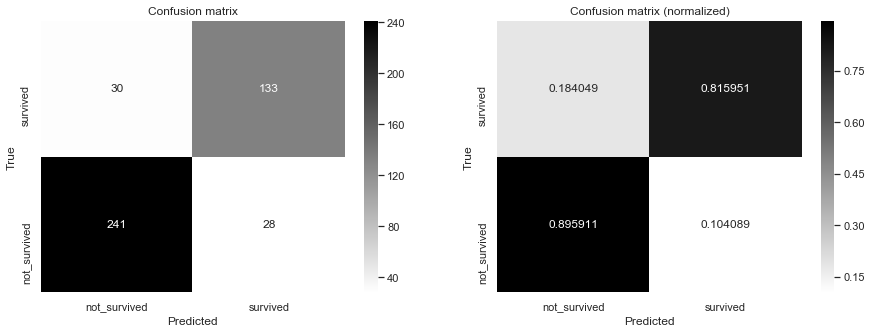

In [78]:
# Mostramos la matriz de confusión del modelo
matrix_logreg = confusion_matrix(y_test, y_test_pred_logreg)
df_matrix_logreg = pd.DataFrame(matrix_logreg, index = ("not_survived", "survived"))
matrix_logreg_normalized = matrix_logreg.astype("float") / matrix_logreg.sum(axis=1)[:, np.newaxis]
df_matrix_logreg_normalized = pd.DataFrame(matrix_logreg_normalized, index = ("not_survived", "survived"))

labels = ["not_survived", "survived"]
akws = {"ha": 'center',"va": 'center'}
f, axes = plt.subplots(1, 2, figsize=(15,5))
sns.heatmap(df_matrix_logreg, annot=True, annot_kws=akws, fmt='g', cmap='gray_r', ax=axes[0])
axes[0].set(xlabel='Predicted', ylabel='True')
axes[0].set_xticklabels(labels)
axes[0].set_ylim([0,2]);
axes[0].set_title("Confusion matrix");

sns.heatmap(df_matrix_logreg_normalized, annot=True, fmt='g', cmap='gray_r',ax=axes[1])
axes[1].set(xlabel='Predicted', ylabel='True')
axes[1].set_xticklabels(labels)
axes[1].set_ylim([0,2]);
axes[1].set_title("Confusion matrix (normalized)");

In [33]:
# Mostramos las métrcias de evaluación del modelo
metrics_logreg = classification_report(y_test, y_test_pred_logreg)
print(metrics_logreg)

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       269
           1       0.83      0.82      0.82       163

    accuracy                           0.87       432
   macro avg       0.86      0.86      0.86       432
weighted avg       0.87      0.87      0.87       432



In [34]:
# Mostramos la precisión del modelo
accuracy_score(y_test, y_test_pred_logreg)

0.8657407407407407

##### Random Forest

In [35]:
# Creamos un modelo de clasificación del tipo RandomForest
model_rf = RandomForestClassifier(criterion="entropy", n_estimators=140, max_depth=5)

# Entrenamos el modelo con el conjunto de train
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=140,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
# Predecimos la variable Survived en el conjunto de test
y_test_pred_rf = model_rf.predict(X_test[:])

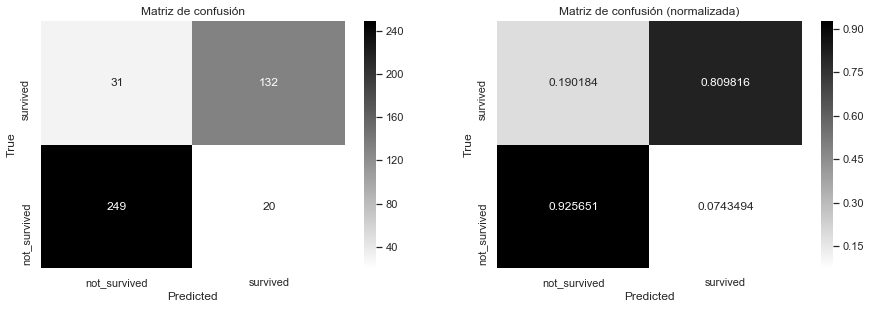

In [76]:
# Mostramos la matriz de confusión del modelo
matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
df_matrix_rf = pd.DataFrame(matrix_rf, index = ("not_survived", "survived"))
matrix_rf_normalized = matrix_rf.astype("float") / matrix_rf.sum(axis=1)[:, np.newaxis]
df_matrix_rf_normalized = pd.DataFrame(matrix_rf_normalized, index = ("not_survived", "survived"))

labels = ["not_survived", "survived"]

f = plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
ax = sns.heatmap(df_matrix_rf, annot=True, ,fmt='g', cmap='gray_r')
ax.set(xlabel='Predicted', ylabel='True')
ax.set_xticklabels(labels)
ax.set_ylim([0,2])
plt.title("Matriz de confusión");
plt.subplot(2,2,2)
ax = sns.heatmap(df_matrix_rf_normalized, annot=True, fmt='g', cmap='gray_r')
ax.set(xlabel='Predicted', ylabel='True')
ax.set_xticklabels(labels)
ax.set_ylim([0,2])
plt.title("Matriz de confusión (normalizada)");

In [38]:
# Mostramos las métrcias de evaluación del modelo
metrics_rf = classification_report(y_test, y_test_pred_rf)
print(metrics_rf)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       269
           1       0.87      0.81      0.84       163

    accuracy                           0.88       432
   macro avg       0.88      0.87      0.87       432
weighted avg       0.88      0.88      0.88       432



In [39]:
# Mostramos la precisión del modelo
accuracy_score(y_test, y_test_pred_rf)

0.8819444444444444

Como se puede observar en el reporte de las métricas obtenidas y en la matriz de confusión, el modelo basado en un Random Forest ofrece mejores resultados que el modelo de regresión logística.

## 5 Representación de los resultados

A continuación vamos a representar graficamente algunas de las informaciones que se han averiguado mediante el análisis de los datos.

In [40]:
# Para facilitar los gráficos, añadimos una nueva columna "Dead" que contendrá 1 si "Survived" es 0, y 0 en el resto de los casos
all_df_imputed["Dead"] =[1 if i==0 else 0 for i in all_df_imputed["Survived"]]

### 5.1 Survived by Sex

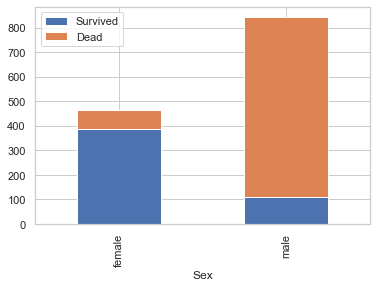

In [41]:
all_df_imputed.groupby("Sex").agg("sum")[["Survived","Dead"]].plot(kind="bar", stacked=True);

Se Observa que prácticamente todas las mujeres se salvaron mientras que practicamente todos los hombres murieron.

### 5.2 Survived by Sex and Age

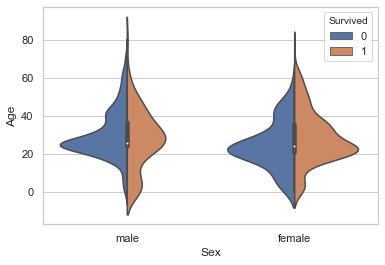

In [42]:
sns.violinplot(x="Sex", y="Age", hue="Survived", data=all_df_imputed, split=True);

Se observa que los hombres entre 20 y 40 años sobrevivieron más que hombres de mayor edad.

### 5.2. Survived by Fare/Pclass

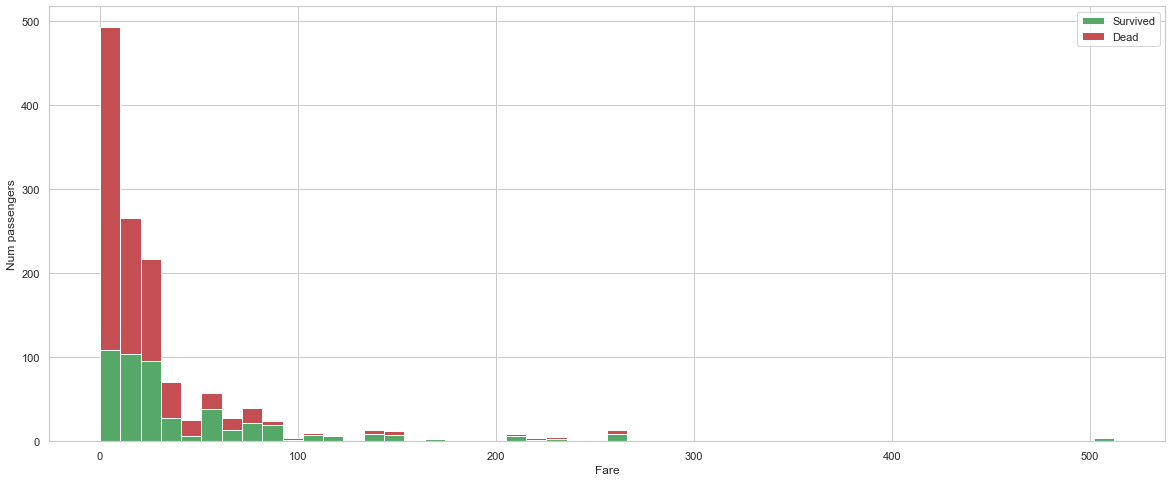

In [80]:
fig = plt.figure(figsize=(20,8))
plt.hist([all_df_imputed[all_df_imputed["Survived"]==1]["Fare"], all_df_imputed[all_df_imputed["Survived"]==0]["Fare"]],
         stacked=True, color=["g","r"], bins=50, label=["Survived", "Dead"]);
plt.xlabel("Fare");
plt.ylabel("Num passengers");
plt.legend();

Se observa que la mayoria de muertos se encuentran entre los que pagaron muy poco por el pasaje. Esto va intimamente ligado con la clase en la que se encontraban.

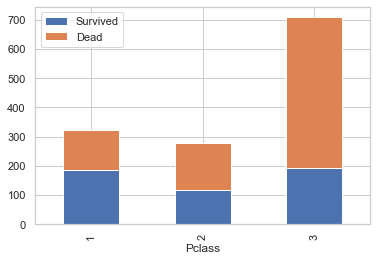

In [44]:
all_df_imputed.groupby("Pclass").agg("sum")[["Survived","Dead"]].plot(kind="bar", stacked=True);

Como ya habiamos predicho, la mayoria de los pasajerons que viajaban en 3a clase murieron. El porcentaje de muertos se reduce si nos fijamos en los pasajeros de 2a clase, y aún se reduce más si nos fijamos en los pasajeros de 1a clase.

### 5.3 Survived by IsAlone

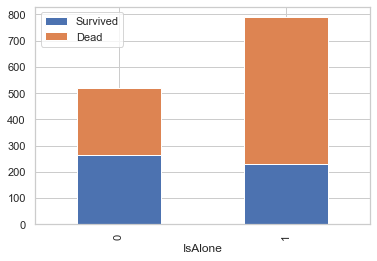

In [45]:
all_df_imputed.groupby("IsAlone").agg("sum")[["Survived","Dead"]].plot(kind="bar", stacked=True);

Otro dato interesante es que 2 tercios de los pasajeros que viajaban solo murieron, mientras que este porcentaje se reduce a tan solo la mitad para los que viajaban en familia. Esto se puede deber a que, como hemos visto, muchos de los niños y mujeres fueron salvados, y si estos viajaban con otros miembros de la familia, estos también fueron salvados.

### 5.4. Survived by Age and Fare

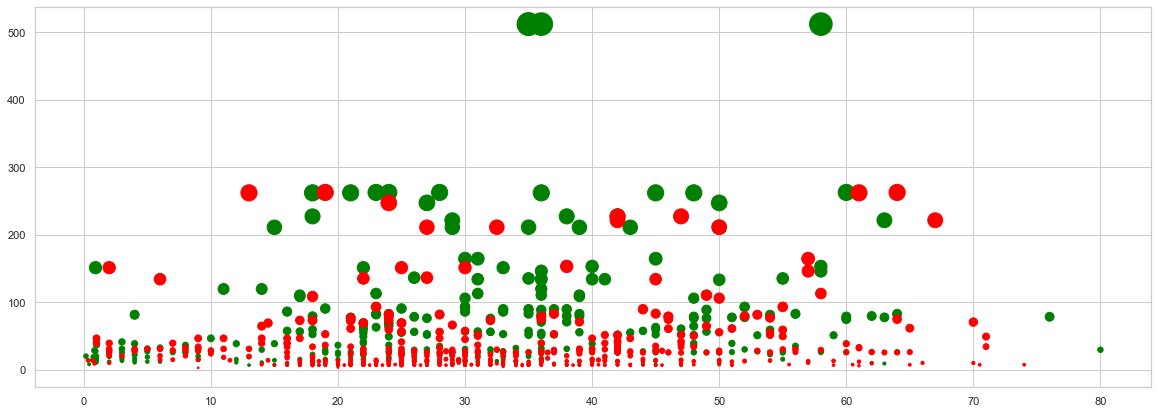

In [46]:
plt.figure(figsize=(20,7))
ax = plt.subplot()

ax.scatter(all_df_imputed[all_df_imputed["Survived"]==1]["Age"], all_df_imputed[all_df_imputed["Survived"]==1]["Fare"],
           c="green", s=all_df_imputed[all_df_imputed["Survived"]==1]["Fare"]);
ax.scatter(all_df_imputed[all_df_imputed["Survived"]==0]["Age"], all_df_imputed[all_df_imputed["Survived"]==0]["Fare"],
           c="red", s=all_df_imputed[all_df_imputed["Survived"]==0]["Fare"]);

Finalmente, este gráfico muestra los supervivientes por edad y coste del billete. Se observa que a medida que se aumenta el precio del billete, los puntos verdes empiezan a crecer en numero, mientras que en lo bajo del gráfico (billetes baratos) abundan los puntos rojos (muertos).

También muestra un dato interesante y es que los niños y personas adultas en su gran mayoria viajaban con billetes baratos y, por lo tanto, en 3a clase, mientras que las personas en un rango de edad intermedia se encuentran esparcidas en todas las 3 clases.

### 5.5 Métricas del modelo de predicción

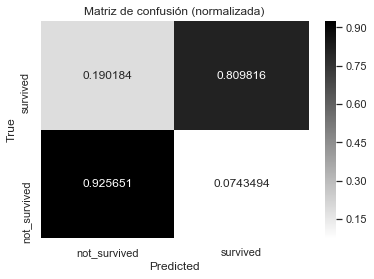

In [82]:
ax = sns.heatmap(df_matrix_rf_normalized, annot=True, fmt='g', cmap='gray_r')
ax.set(xlabel='Predicted', ylabel='True')
ax.set_xticklabels(labels)
ax.set_ylim([0,2])
plt.title("Matriz de confusión (normalizada)");

## 6 Resolución del problema

El objetivo inicial era el de detectar patrones en el conjunto de datos para tratar de determinar que factores determinaron el hecho de sobrevivir o no al accidente que sufrió el Titanic. Como hemos visto claramente representado en el apartado anterior, hemos podido detectar la influencia que tuvieron hechos como el de ser mujer o hombre, viajar solo o viajar en familia, viajar en primera clase o viajar en clases inferiores, etc. en el hecho de sobrevivir o no.

Además, hemos definido un modelo de predicción que permite obtener la probabilidad de superviviencia de un pasajero dado con una precisión de alrededor del 0.88. Cabe destacar que este modelo se podría mejorar buscando los parámetros más óptimos para el modelo, o incluso usando modelos y técnicas más avanzadas.


## 7 Recursos

-	Calvo M., Subirats L., Pérez D. (2019). Introducción a la limpieza y análisis de los datos. Editorial UOC.

-	Megan Squire (2015). Clean Data. Packt Publishing Ltd.

-	Jiawei Han, Micheine Kamber, Jian Pei (2012). Data mining: concepts and techniques. Morgan Kaufmann.

-	Jason W. Osborne (2010). Data Cleaning Basics: Best Practices in Dealing with Extreme Scores. Newborn and Infant Nursing Reviews; 10 (1): pp. 1527-3369.

-	Peter Dalgaard (2008). Introductory statistics with R. Springer Science & Business Media.

-	Wes McKinney (2012). Python for Data Analysis. O’Reilley Media, Inc.